# 前処理色々

ライブラリのインポート

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.sparse.linalg import cg

各種パラメータ

In [178]:
#グリッドについて
n_grid = 1024 # number of grid points
right_edge = 1024 # right edge of the simulation box
dx = 1 # grid spacing
grid = np.arange(n_grid+1) * dx # 0, 1, ..., 1024
grid_half = (np.arange(n_grid) + 0.5) * dx # 0.5, 1.5, ..., 1023.5

#粒子について
density_per_cell = 4 # particles per cell
n_particle = n_grid * density_per_cell # total number of particles
n_e = density_per_cell * dx * (1/2) # number of electrons
e = 1/n_e # 電荷素量    
m = np.ones(n_particle) 
q = np.ones(n_particle) 
m_ion = 100
for i in range(n_particle):
    if i % 2 == 0:
        q[i] = e # ion
        m[i] = m_ion*e
    else:
        q[i] = -e # electron
        m[i] = 1.0*e

# シミュレーションパラメータ
v_e = 1.0  # 電子の熱速度
v_ion = v_e * np.sqrt(1/m_ion) # イオンの熱速度
epsilon = 1.0   # 真空の誘電率
c = 50.0 # 光速
mu = 1.0 / (epsilon * c**2) # 真空の透磁率
theta = 0.505 # imlicitnessパラメータ

#時間について
dt = 0.01 # time step
tmax = 40.0 # maximum time
t = 0.0
n_step = int(tmax / dt)

初期条件の設定

In [179]:
A=0.05
k =2*np.pi/(n_grid*dx)
#粒子の初期配置
x = 1024 * (np.random.rand(n_particle))
#x = 1+A*np.cos(k*x)
y = np.zeros(n_particle)
z = np.zeros(n_particle)
u = np.zeros(n_particle)
v = np.zeros(n_particle)
w = np.zeros(n_particle)
u[0::2] = v_ion/3 * np.random.randn(n_particle//2)  # イオンの速度(偶数index)
u[1::2] = v_e/3 * np.random.randn(n_particle//2)    # 電子の速度(奇数index)
v[0::2] = v_ion/3 * np.random.randn(n_particle//2)
v[1::2] = v_e/3 * np.random.randn(n_particle//2)
w[0::2] = v_ion/3 * np.random.randn(n_particle//2)
w[1::2] = v_e/3 * np.random.randn(n_particle//2)

# 電場, 磁場の初期条件
def magnetic_field(x, y):
    Bx = 0.0 * np.ones_like(y)
    By = 0.0 * np.ones_like(y)
    Bz = 1.0 * np.ones_like(y)
    Ex = 0.0* np.sin(2 * np.pi * y / 128)
    Ey = 0.0 * np.ones_like(x)
    Ez = 0.0 * np.ones_like(x)
    return Bx, By, Bz, Ex, Ey, Ez
Bx_grid, By_grid, Bz_grid, Ex_grid, Ey_grid, Ez_grid = magnetic_field(grid, grid_half) #グリッド上での磁場と電場

# 各種関数

速度の更新(Buneman-Boris法)

In [180]:
# 電磁場の補完
def field_interpolation(x, n_grid, Bx_grid, By_grid, Bz_grid, Ex_grid, Ey_grid, Ez_grid):
    # まずはハーフグリッドで定義されている電磁場をグリッドに置き直す(磁場とExのみ)
    Bx_on_grid = np.zeros(n_grid+1)
    By_on_grid = np.zeros(n_grid+1)
    Bz_on_grid = np.zeros(n_grid+1)
    Ex_on_grid = np.zeros(n_grid+1)
    for i in range(n_grid+1):
        ip = i%n_grid
        im = (i+1)%n_grid
        Bx_on_grid[i] = (Bx_grid[ip] + Bx_grid[im]) / 2
        By_on_grid[i] = (By_grid[ip] + By_grid[im]) / 2
        Bz_on_grid[i] = (Bz_grid[ip] + Bz_grid[im]) / 2
        Ex_on_grid[i] = (Ex_grid[ip] + Ex_grid[im]) / 2

    Ex_particles = np.zeros(len(x))
    Bx_particles = np.zeros(len(x))
    Ey_particles = np.zeros(len(x))
    By_particles = np.zeros(len(x))
    Ez_particles = np.zeros(len(x))
    Bz_particles = np.zeros(len(x))

    for i in range(len(x)):
        xi = x[i]

        L = n_grid * dx
        xi_p = xi % L          # ← これが最重要

        ig = int(xi_p // dx)
        igp = (ig + 1) % n_grid

        xg = ig * dx
        s1 = (xi_p - xg) / dx
        s0 = 1.0 - s1

        Ex_particles[i] = s0 * Ex_on_grid[ig] + s1 * Ex_on_grid[igp]
        Ey_particles[i] = s0 * Ey_grid[ig] + s1 * Ey_grid[igp]
        Ez_particles[i] = s0 * Ez_grid[ig] + s1 * Ez_grid[igp]

        Bx_particles[i] = s0 * Bx_on_grid[ig] + s1 * Bx_on_grid[igp]
        By_particles[i] = s0 * By_on_grid[ig] + s1 * By_on_grid[igp]
        Bz_particles[i] = s0 * Bz_on_grid[ig] + s1 * Bz_on_grid[igp]

    return Bx_particles, By_particles, Bz_particles, Ex_particles, Ey_particles, Ez_particles

# 速度の更新
def buneman_boris_push(u, v, w, q, m, dt, Ex, Ey, Ez, Bx, By, Bz):
    Sx = np.zeros(n_particle)
    Sy = np.zeros(n_particle)
    Sz = np.zeros(n_particle)
    Tx = np.zeros(n_particle)
    Ty = np.zeros(n_particle)
    Tz = np.zeros(n_particle)
    u_minus = np.zeros(n_particle)
    v_minus = np.zeros(n_particle)
    w_minus = np.zeros(n_particle)
    u_zero = np.zeros(n_particle)
    v_zero = np.zeros(n_particle)
    w_zero = np.zeros(n_particle)
    u_plus = np.zeros(n_particle)
    v_plus = np.zeros(n_particle)
    w_plus = np.zeros(n_particle)
    for i in range(n_particle):
        # Boris pusher の係数
            Tx[i] = (q[i] / m[i]) * Bx[i] * 0.5 * dt
            Ty[i] = (q[i] / m[i]) * By[i] * 0.5 * dt
            Tz[i] = (q[i] / m[i]) * Bz[i] * 0.5 * dt
            Sx[i] = 2.0 * Tx[i] / (1.0 + Tx[i]**2 + Ty[i]**2 + Tz[i]**2)
            Sy[i] = 2.0 * Ty[i] / (1.0 + Tx[i]**2 + Ty[i]**2 + Tz[i]**2)
            Sz[i] = 2.0 * Tz[i] / (1.0 + Tx[i]**2 + Ty[i]**2 + Tz[i]**2)

            # --- Boris step ---
            u_minus[i] = u[i] + (q[i]/m[i]) * Ex[i] * 0.5 * dt
            v_minus[i] = v[i] + (q[i]/m[i]) * Ey[i] * 0.5 * dt
            w_minus[i] = w[i] + (q[i]/m[i]) * Ez[i] * 0.5 * dt

            u_zero[i] = u_minus[i] + (v_minus[i] * Tz[i] - w_minus[i] * Ty[i])
            v_zero[i] = v_minus[i] - (u_minus[i] * Tz[i] - w_minus[i] * Tx[i])
            w_zero[i] = w_minus[i] + (u_minus[i] * Ty[i] - v_minus[i] * Tx[i])


            u_plus[i] = u_minus[i] + (v_zero[i] * Sz[i] - w_zero[i] * Sy[i])
            v_plus[i] = v_minus[i] - (u_zero[i] * Sz[i] - w_zero[i] * Sx[i])
            w_plus[i] = w_minus[i] + (u_zero[i] * Sy[i] - v_zero[i] * Sx[i])

            # 速度更新(t - dt/2 -> t + dt/2)
            u[i] = u_plus[i] + (q[i]/m[i]) * Ex[i] * 0.5 * dt
            v[i] = v_plus[i] + (q[i]/m[i]) * Ey[i] * 0.5 * dt
            w[i] = w_plus[i] + (q[i]/m[i]) * Ez[i] * 0.5 * dt
    return u, v, w

電荷保存法(Jxの計算に用いる)

In [181]:
def deposit_current_esirkepov(x_old, x_new, q, n_grid, dx, dt):
    Jx = np.zeros(n_grid+2)  # half grid

    for p in range(len(x_old)):
        xp0 = x_old[p]
        xp1 = x_new[p]
        dq = q[p]

        L = n_grid * dx
        xp0 = xp0 % L
        xp1 = xp1 % L

        # 最近接表現に直す（重要）
        dxp = xp1 - xp0
        if dxp >  L/2: xp1 -= L
        if dxp < -L/2: xp1 += L


        # 方向
        sgn = np.sign(xp1 - xp0)
        if sgn == 0:
            continue
        elif sgn > 0:
            A = xp0
            B = xp1
            C = 1
        else:
            A = xp1
            B = xp0
            C = -1

        i0 = int(xp0 // dx)
        i1 = int(xp1 // dx)

        if xp1 > xp0:
            cells = range(i0, i1+1)
        else:
            cells = range(i1, i0+1)

        for k in cells: # AからBまでのセルをループ, Cは方向
            xL = max(A, k*dx)
            xR = min(B, (k+1)*dx)
            dl = xR - xL
            if dl > 0:
                Jx[(k+1) % n_grid] += dq * C * dl / (dt * dx) # 境界を飛び越えても対応

    return Jx

CIC法による電荷散布(Jy, Jzの計算に用いる)

In [182]:
# 重みの計算
def lower_index(x, grid):
    idx = np.searchsorted(grid, x) - 1
    n_grid = len(grid) - 1
    return idx % n_grid

def deposit_charge(x, q, n_grid, dx, lower_idx, v, w):
    S = np.zeros(n_grid+1) # 電荷の形状関数の積分を表す
    rho = np.zeros(n_grid+1)
    Jy  = np.zeros(n_grid+1)
    Jz  = np.zeros(n_grid+1)

    for i in range(len(x)):
        i0 = lower_idx[i]
        i1 = i0 + 1

        xi = (x[i] - grid[i0]) / dx
        s0 = 1.0 - xi
        s1 = xi

        S[i0] += s0
        S[i1] += s1
        rho[i0] += q[i] * s0 / dx
        rho[i1] += q[i] * s1 / dx
        Jy[i0]  += q[i] * v[i] * s0 / dx
        Jy[i1]  += q[i] * v[i] * s1 / dx
        Jz[i0]  += q[i] * w[i] * s0 / dx
        Jz[i1]  += q[i] * w[i] * s1 / dx

    return S, rho, Jy, Jz

1D陰的FDTD法

In [183]:
def implicit_FDTD_1d(Bx_grid, By_grid, Bz_grid, Ex_grid, Ey_grid, Ez_grid, grid, grid_half, n_grid, Jx, Jy, Jz):
    b_x = np.zeros_like(grid_half)
    b_y = np.zeros_like(grid_half)
    b_z = np.zeros_like(grid_half)

    for i in range(n_grid):
        ip1 = (i + 1) % n_grid
        ip0 = i % n_grid    
        ipm = (i - 1) % n_grid
        b_x[i] = theta * (c * dt)**2 * ((Bx_grid[ip1] - 2 * Bx_grid[ip0] + Bx_grid[ipm]) / (dx**2))
        b_y[i] = theta * (c * dt)**2 * ((By_grid[ip1] - 2 * By_grid[ip0] + By_grid[ipm]) / (dx**2)) - theta * dt**2/epsilon * ((Jz[ip0] - Jz[ipm]) / dx)
        b_y[i] += dt * ((Ez_grid[ip0] - Ez_grid[ipm]) / dx)
        b_z[i] = theta * (c * dt)**2 * ((Bz_grid[ip1] - 2 * Bz_grid[ip0] + Bz_grid[ipm]) / (dx**2)) + theta * dt**2/epsilon * ((Jy[ip0] - Jy[ipm]) / dx)
        b_z[i] += - dt * ((Ey_grid[ip0] - Ey_grid[ipm]) / dx)
    # --- b の平均除去 ---
    b_x -= np.mean(b_x)
    b_y -= np.mean(b_y)
    b_z -= np.mean(b_z)

    alpha2 = (theta * c * dt / dx)**2

    A = np.zeros((n_grid, n_grid))
    for i in range(n_grid):
        A[i, i] = 1 + 2 * alpha2
        A[i, (i-1) % n_grid] = -alpha2
        A[i, (i+1) % n_grid] = -alpha2
    delta_Bx,info_bx = cg(A, b_x, rtol=1e-10, maxiter=1000)
    delta_By,info_by = cg(A, b_y, rtol=1e-10, maxiter=1000)
    delta_Bz,info_bz = cg(A, b_z, rtol=1e-10, maxiter=1000)

    delta_Ex = np.zeros_like(grid_half)
    delta_Ey = np.zeros_like(grid)
    delta_Ez = np.zeros_like(grid)

    for i in range(n_grid):
        ip0 = i % n_grid
        delta_Ex[ip0] = - dt / epsilon * Jx[ip0]


    for i in range(n_grid+1):
        ip1 = (i + 1) % n_grid
        ip0 = i % n_grid
        ipm = (i - 1) % n_grid
        delta_Ey[i] = - dt / epsilon * Jy[ip0]
        delta_Ey[i] += (c ** 2) * (dt * (-(Bz_grid[ip1] - Bz_grid[ip0])) / dx + dt * theta * (-(delta_Bz[ip1] - delta_Bz[ip0])) / dx)
        delta_Ez[i] = - dt / epsilon * Jz[ip0]
        delta_Ez[i] += (c ** 2) * (dt * ( (By_grid[ip1] - By_grid[ip0])) / dx + dt * theta * ( (delta_By[ip1] - delta_By[ip0])) / dx)

    delta_Ex -= np.mean(delta_Ex)

    return delta_Bx, delta_By, delta_Bz, delta_Ex, delta_Ey, delta_Ez

# メインループ

In [184]:
lower_idx = lower_index(x, grid)
S, rho, Jy, Jz = deposit_charge(x, q, n_grid, dx, lower_idx, v, w)
j = np.arange(len(Ex_grid))
Ng = len(grid) - 1
# Poisson方程式に整合するように電場を修正
for i in range(n_particle):
        k = lower_idx[i]
        kp = k % Ng
        kp1 = (k + 1) % Ng
        Ex_grid[j-1 < kp]     += - q[i] / (2 * epsilon)
        Ex_grid[j-1 == kp]  += q[i] / (2 * epsilon) * (S[kp] - S[kp1])
        Ex_grid[j-1 > kp]   += q[i] / (2 * epsilon)
Ex_grid -= np.mean(Ex_grid)  # 平均値を引く

In [185]:
t_list = []
kinetic_list = []
electric_list = []
magnetic_list = []
total_list = []

In [186]:
step = 0
while t < tmax:
    #エネルギーの計算
    kinetic = 0.5 * np.sum(m * (u**2 + v**2 + w**2)) # 運動エネルギー
    electric = 0.5 * epsilon * (np.sum(Ex_grid**2) + np.sum(Ey_grid**2) + np.sum(Ez_grid**2)) * dx # 電場エネルギー
    magnetic = 0.5 * (1/mu) * (np.sum(Bz_grid**2) + np.sum(By_grid**2) + np.sum((Bx_grid)**2)) * dx # 磁場エネルギー
    total = kinetic + electric + magnetic
    # データの保存
    t_list.append(t)
    kinetic_list.append(kinetic)
    electric_list.append(electric)
    magnetic_list.append(magnetic)
    total_list.append(total)

    # 電磁場の補完
    Bx_particles, By_particles, Bz_particles, Ex_particles, Ey_particles, Ez_particles = field_interpolation(x, n_grid, Bx_grid, By_grid, Bz_grid, Ex_grid, Ey_grid, Ez_grid)

    # 速度の更新
    u, v, w = buneman_boris_push(u, v, w, q, m, dt, Ex_particles, Ey_particles, Ez_particles, Bx_particles, By_particles, Bz_particles)

    # 位置の更新
    x_old = np.copy(x)
    x += u * dt

    # xについて周期境界条件
    x = x % right_edge
    x_old = x_old % right_edge

    # 電流の堆積
    Jx = deposit_current_esirkepov(x_old, x, q, n_grid, dx, dt)

    lower_indexs = lower_index(x, grid)
    S,rho, Jy, Jz = deposit_charge(x, q, n_grid, dx, lower_indexs, v, w)
    # 電磁場の更新
    delta_Bx, delta_By, delta_Bz, delta_Ex, delta_Ey, delta_Ez = implicit_FDTD_1d(Bx_grid, By_grid, Bz_grid, Ex_grid, Ey_grid, Ez_grid, grid, grid_half, n_grid, Jx, Jy, Jz)

    Bx_grid += delta_Bx
    By_grid += delta_By
    Bz_grid += delta_Bz
    Ex_grid += delta_Ex
    Ey_grid += delta_Ey
    Ez_grid += delta_Ez

    t += dt
    step += 1
    if step % 100 == 0:
        print(str(step/ n_step * 100) + " % completed")

2 % completed
5 % completed
7 % completed
10 % completed
12 % completed
15 % completed
17 % completed
20 % completed
22 % completed
25 % completed
27 % completed
30 % completed
32 % completed
35 % completed
37 % completed
40 % completed
42 % completed
45 % completed
47 % completed
50 % completed
52 % completed
55 % completed
57 % completed
60 % completed
62 % completed
65 % completed
67 % completed
70 % completed
72 % completed
75 % completed
77 % completed
80 % completed
82 % completed
85 % completed
87 % completed
90 % completed
92 % completed
95 % completed
97 % completed
100 % completed


# プロット

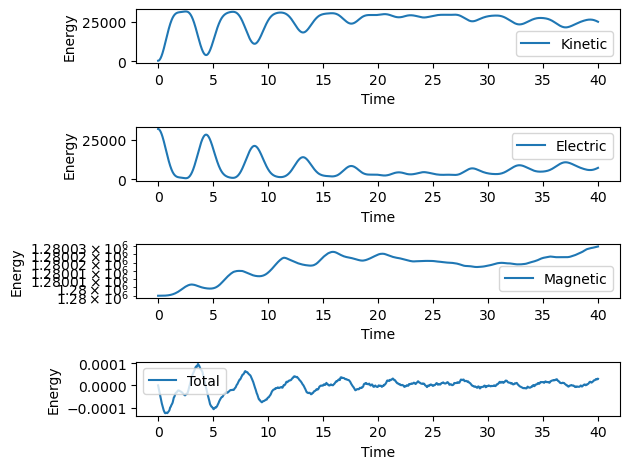

In [187]:
plt.figure()
plt.subplot(4,1,1)
plt.plot(t_list, kinetic_list, label='Kinetic')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()

plt.subplot(4,1,2)
plt.plot(t_list, electric_list, label='Electric')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()

plt.subplot(4,1,3)
plt.plot(t_list, magnetic_list, label='Magnetic')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.yscale('log')
plt.legend()

plt.subplot(4,1,4)
plt.plot(t_list, (total_list-total_list[0])/total_list[0], label='Total')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.tight_layout()
plt.show()

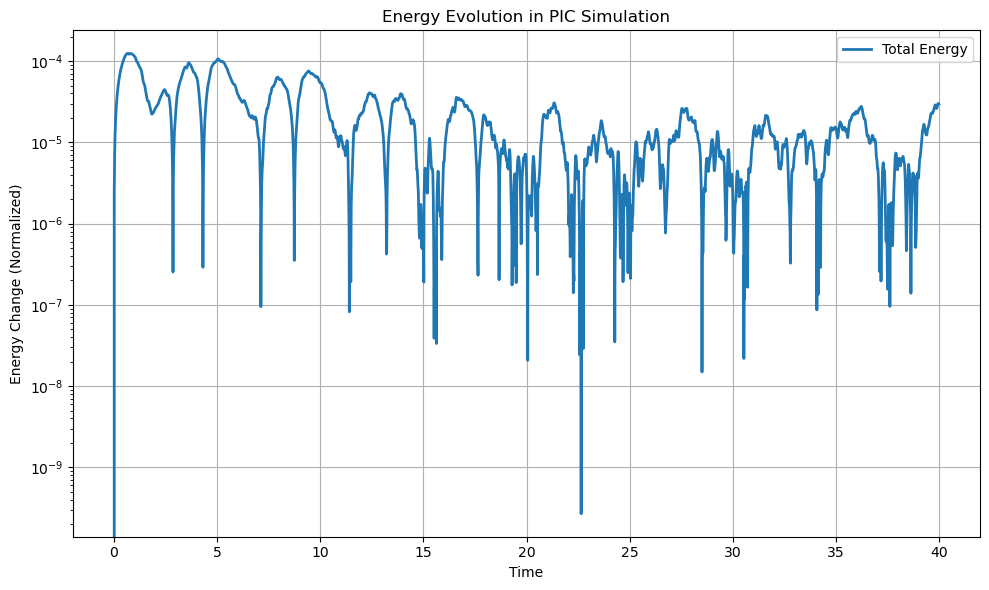

In [188]:
plt.figure(figsize=(10,6))

plt.plot(
        t_list,
        abs(total_list-total_list[0]) / (kinetic_list[0] + electric_list[0] + magnetic_list[0]),
        label="Total Energy",
        linewidth=2
    )

plt.yscale("log")

plt.xlabel("Time")
plt.ylabel("Energy Change (Normalized)")
plt.legend()
plt.title("Energy Evolution in PIC Simulation")
plt.grid()
plt.tight_layout()
plt.show()